# U-net MODEL for liver segmentation from CT images

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!pip install pydicom SimpleITK tensorboardcolab albumentations scikit-image medpy keras==2.1.4

     |████████████████████████████████| 7.1MB 2.7MB/s 
     |████████████████████████████████| 42.5MB 1.6MB/s 
     |████████████████████████████████| 153kB 58.0MB/s 
     |████████████████████████████████| 327kB 56.4MB/s 
     |████████████████████████████████| 634kB 60.1MB/s 
  Created wheel for medpy: filename=MedPy-0.4.0-cp36-cp36m-linux_x86_64.whl size=753423 sha256=d780b743f832cf4070d84da6c961d254451b523e47430b61bbc302fe8565db87
  Stored in directory: /root/.cache/pip/wheels/8c/c9/9c/2c6281c7a72b9fb1570862a4f028af7ce38405008354fbf870
  Created wheel for imgaug: filename=imgaug-0.2.6-cp36-none-any.whl size=654020 sha256=3f13f8e292a298b81a696cc03f61258c890f34b44d947e0f8ae9d79940cceffa
  Stored in directory: /root/.cache/pip/wheels/97/ec/48/0d25896c417b715af6236dbcef8f0bed136a1a5e52972fc6d0
Successfully built medpy imgaug
ERROR: textgenrnn 1.4.1 has requirement keras>=2.1.5, but you'll have keras 2.1.4 which is incompatible.
  Found existing installation: Keras 2.2.5
    Uninstallin

### Import dependecies and setup main directory to google drive directory 

# New Section

In [0]:
import os
import random
import pydicom
import numpy as np
import cv2
from tqdm import tqdm
import SimpleITK as sitk
import matplotlib.pyplot as plt
import pickle
from skimage import feature
import tables
from functools import partial
from albumentations import (
    Compose, HorizontalFlip, VerticalFlip, ShiftScaleRotate
)

In [0]:
COLUMNS, ROWS = 512, 512
main_dir = '/content/drive/My Drive/DP - Prototype'
data_dir = f'{main_dir}/data'
channels = 1

## Open HDF file
HDF allow to read file in baches from disc during the training phase instead of reading all data to RAM at once. 

In [0]:
train_file = tables.open_file(f'{main_dir}/CT-train.h5', mode="r")
print(train_file)

/content/drive/My Drive/DP - Prototype/CT-train.h5 (File) ''
Last modif.: 'Tue Nov 12 21:25:55 2019'
Object Tree: 
/ (RootGroup) ''
/x (CArray(2874, 512, 512), shuffle, blosc(5)) ''
/y (CArray(2874, 512, 512), shuffle, blosc(5)) ''



In [0]:
x_train = train_file.get_node('/x')
y_train = train_file.get_node('/y')

In [0]:
OPEN_MODEL = 'unet-REG-50-CROSSENTROPY-AUGM-corr(ckpt)'

### Plot slices

In [0]:
def plot_slice(x, y):
  counter = 1
  if len(x.shape) > 2:
    length = x.shape[2] + 1
  else:
    length = 2
  
  figure = plt.figure(figsize=(20, 20))
  if len(x.shape) > 2 and x.shape[2] == 2:
    plt.subplot(1, length, counter) 
    plt.imshow(np.nan_to_num(x[:, :, 0]), cmap="bone")
    counter += 1
  
    plt.subplot(1, length, counter) 
    plt.imshow(np.nan_to_num(x[:, :, 1]), cmap="bone")
    counter += 1
    
  else:
    if len(y.shape) > 2:
      plt.subplot(1, length, counter) 
      plt.imshow(np.nan_to_num(x[:, :, 0]), cmap="bone")
      counter += 1
    else:
      plt.subplot(1, length, counter) 
      plt.imshow(np.nan_to_num(x), cmap="bone")
      counter += 1
    
  
  if len(y.shape) > 2:
    plt.subplot(1, length, counter)
    plt.imshow(np.nan_to_num(y[:, :, 0]), cmap="bone")
   
  else:
    plt.subplot(1, length, counter)
    plt.imshow(np.nan_to_num(y), cmap="bone")
  
  plt.show()

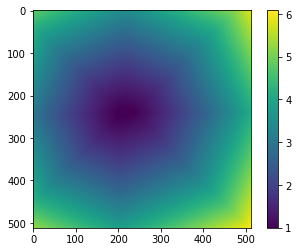

In [0]:
slice_n = 5
y = y_train[slice_n]
dt = distance_transform_weight(y)
plt.imshow(dt)
plt.colorbar()
# plot_slice(dt / 255, y_train[slice_n])

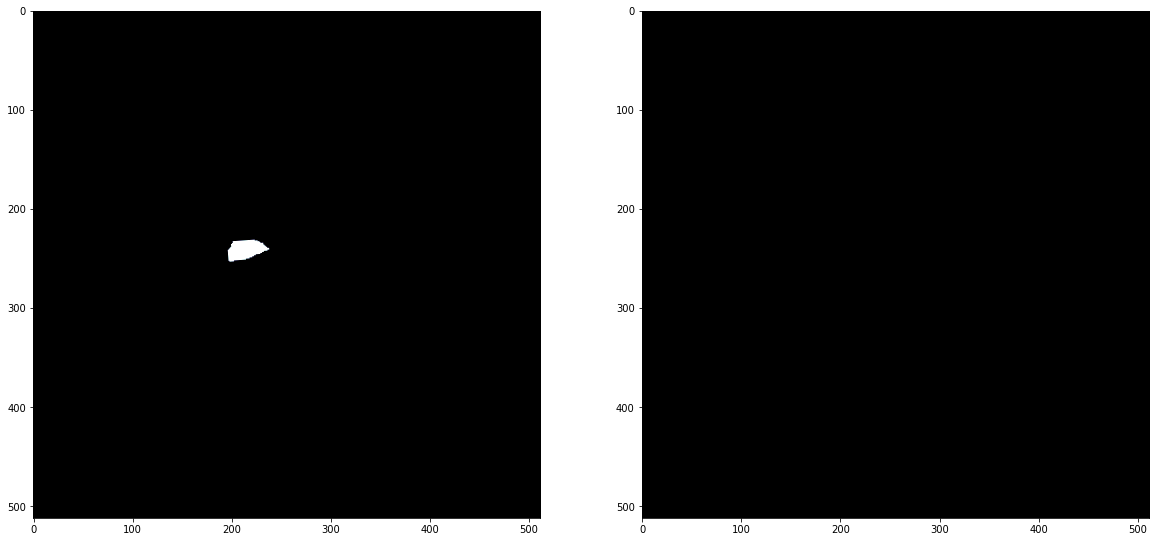

In [0]:
plot_slice(y, x)

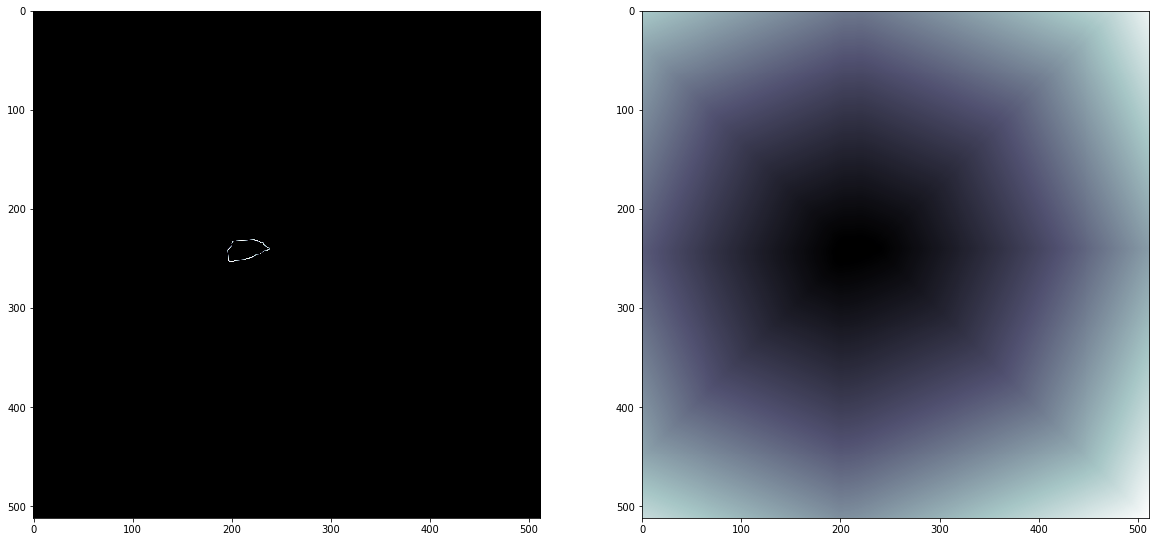

Binary crossentropy 0.00019890617
Weighted Binary crossentropy 0.00020050857


In [0]:
x = y
dt = distance_transform_weight(x);

xK = K.constant(x)
yK = K.constant(y)
wK = K.constant(dt)
binary_cross = K.get_value(K.binary_crossentropy(yK, xK))
weight_binary_cross = K.get_value(K.binary_crossentropy(yK, xK) * wK)
plot_slice(binary_cross, dt)

print('Binary crossentropy', np.mean(binary_cross))
print('Weighted Binary crossentropy', np.mean(weight_binary_cross))

#### Image plots


In [0]:
fig = plt.figure(figsize=(15,15))

for num in range(1,26):
    ax = fig.add_subplot(5,5,num)
    plt.imshow(x_train[num].reshape((COLUMNS, ROWS)), cmap="bone")

plt.tight_layout()
plt.show()

In [0]:
fig = plt.figure(figsize=(15,15))

for num in range(1,26):
    ax = fig.add_subplot(5,5,num)
    plt.imshow(y_train[num].reshape((COLUMNS, ROWS)), cmap="bone")

plt.tight_layout()
plt.show()

## Utils
We define set of helper functions which includes metrics, generator or local binary patterns operation.

In [0]:
%tensorflow_version 1.x
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.metrics import Recall
import tensorflow.keras.backend as K
from tensorboardcolab import TensorBoardColab, TensorBoardColabCallback
from distutils.dir_util import copy_tree
from sklearn.metrics import accuracy_score
from functools import partial

print(tf.test.is_gpu_available())

Using TensorFlow backend.


True


In [0]:
def weighted_binary_crossentropy(y_true, y_pred, weights_input, sample_weight=None):
  return K.mean(K.binary_crossentropy(y_true, y_pred) * weights_input)

In [0]:
smooth = 0.000001
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

In [0]:
def round_sigmoid(x):
    res = K.sigmoid(x)
    return K.relu()

In [0]:
def get_local_binary_pattern(x):
  res = feature.local_binary_pattern(x.copy(), 8 * 2, 4, 'default')
  print(res.shape, res.dtype)
  return res
  

In [0]:
def distance_transform_weight(x):
    x = 1 - x
    x *= 255
    x = x.astype(np.uint8)
    dt = cv2.distanceTransform(x, cv2.DIST_L2, 3)
    dt = (dt / 255)
    dt = dt ** 2
    dt = (dt / dt.max()) * 1.5
    return  dt + 1

In [0]:
def generator(X_data, y_data, batch_size, indices, augmentation, LBP=False, weights=True):
    indx = indices
    samples_per_epoch = len(indx)
    number_of_batches = samples_per_epoch / batch_size
    counter = 0

    channels = 1
    if LBP:
      channels = 2

    while 1:
        start = batch_size * counter
        stop = batch_size * (counter + 1)
        indxs = indx[start:stop]
        shape = X_data.shape

        X_batch = np.zeros((batch_size, X_data.shape[1], X_data.shape[2], 1))
        y_batch = np.zeros((batch_size, y_data.shape[1], y_data.shape[2], 1))

        if weights:
          weights_batch = np.zeros((batch_size, y_data.shape[1], y_data.shape[2], 1))

        
        for i, idx in enumerate(indxs):
            if augmentation is not None:
                x = np.nan_to_num(X_data[idx])
                y = np.nan_to_num(y_data[idx])
                aug = augmentation(image=x, mask=y)
                y_batch[i] = aug["mask"].reshape((shape[1], shape[2], 1))

                if weights:
                  weights_batch[i] = distance_transform_weight(aug["mask"]).reshape((shape[1], shape[2], 1))
                
                if LBP:
                  lbp = get_local_binary_pattern(aug["image"])
                  X_batch[i, :, :, 0] = np.nan_to_num(lbp)
                else:
                  X_batch[i, :, :] = aug["image"].reshape((shape[1], shape[2], 1))
                  


        counter += 1
        if weights:
          yield [X_batch.astype(np.float64), weights_batch.astype(np.float64)], y_batch.astype(np.float64)
        else:
          yield X_batch.astype(np.float64), y_batch.astype(np.float64)

        # restart counter to yeild data in the next epoch as well
        if counter >= number_of_batches:
            np.random.shuffle(indx)
            counter = 0

#### Split to train and validation set
We are using first 16 patient from the training set as train set and remaining 4 patients as validation set. Split 2302 is the first slice of the patient in validation set. 

In [0]:
with open(f'{main_dir}/patient_slices.pkl', 'rb') as input:
    patient_slices = pickle.load(input)
    print(patient_slices)

[{'id': '1', 'slices': 96}, {'id': '10', 'slices': 110}, {'id': '14', 'slices': 95}, {'id': '16', 'slices': 91}, {'id': '18', 'slices': 111}, {'id': '19', 'slices': 90}, {'id': '2', 'slices': 81}, {'id': '21', 'slices': 257}, {'id': '22', 'slices': 101}, {'id': '23', 'slices': 240}, {'id': '24', 'slices': 123}, {'id': '25', 'slices': 235}, {'id': '26', 'slices': 114}, {'id': '27', 'slices': 242}, {'id': '28', 'slices': 102}, {'id': '29', 'slices': 214}, {'id': '30', 'slices': 266}, {'id': '5', 'slices': 95}, {'id': '6', 'slices': 88}, {'id': '8', 'slices': 123}]


In [0]:
def sum_slices(arr):
  return np.sum(list(map(lambda x: x["slices"], arr)))

In [0]:
## TOTAL 20 patients arond 100 slices per patient 
ALL_SIZE = sum_slices(patient_slices)
print('All slices:', ALL_SIZE)

patients_len = len(patient_slices)
train_split = int(0.7 * patients_len)
val_split = int(0.1 * patients_len)
test_split = int(0.2 * patients_len)

train_patients = patient_slices[:train_split] 
val_patients = patient_slices[train_split:train_split + val_split]
test_patients = patient_slices[train_split + val_split:]

indices = np.arange(ALL_SIZE)

train_size = sum_slices(train_patients)
val_size = sum_slices(val_patients)
test_size = sum_slices(test_patients)

train_ind = indices[:train_size]
eval_ind = indices[train_size:train_size + val_size]
test_ind = indices[train_size + val_size:]

All slices: 2874


In [0]:
print("Train IND (example):", train_ind[:10], ', shape:', train_ind.shape)
print("Validation IND (example):", eval_ind[:10], ', shape:', eval_ind.shape)
print("TEST IND (example):", test_ind[:10], ', shape:', test_ind.shape)

Train IND (example): [0 1 2 3 4 5 6 7 8 9] , shape: (1986,)
Validation IND (example): [1986 1987 1988 1989 1990 1991 1992 1993 1994 1995] , shape: (316,)
TEST IND (example): [2302 2303 2304 2305 2306 2307 2308 2309 2310 2311] , shape: (572,)


##### Test Activation function

In [0]:
x = K.constant(np.array([[0, 0]]))
y = K.constant(np.array([[1, 1]]))
w = K.constant(np.array([[1, 1.0]]))
print(K.get_value(weighted_binary_crossentropy(y, x, w)))

15.424949


In [0]:
x = np.array([[[0, 0], [1, 0]]])
y = np.array([[[0, 0], [1, 0]]])
K.get_value(K.mean(K.binary_crossentropy(K.constant(x), K.constant(y), None)))

##### Example local binary patterns

In [0]:
slice_n = 560
x_slice = x_train[slice_n]
x_lbp = get_local_binary_pattern(x_slice)
plot_slice(x_slice, x_lbp)

## Train model

### Data Augmentation - Albumentations

In [0]:
TRAIN_AUGMENT = Compose([
    ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=8, border_mode=cv2.BORDER_CONSTANT, p=0.8),
])

### Model

Keras implementation of U-net was originaly posted [here](https://github.com/zhixuhao/unet/blob/master/model.py). Code was modified as we were experimenting with number of filters in the network.

In [0]:
def u_net(input_shape, distance_transform=False):

    weighted_loss = '_'

    inputs = Input(input_shape)
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same')(inputs)
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(64, 3, activation = 'relu', padding = 'same')(pool1)
    conv2 = Conv2D(64, 3, activation = 'relu', padding = 'same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(128, 3, activation = 'relu', padding = 'same')(pool2)
    conv3 = Conv2D(128, 3, activation = 'relu', padding = 'same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(256, 3, activation = 'relu', padding = 'same')(pool3)
    conv4 = Conv2D(256, 3, activation = 'relu', padding = 'same')(conv4)
    drop4 = Dropout(0.5)(conv4)

    up7 = Conv2D(128, 2, activation = 'relu', padding = 'same')(UpSampling2D(size = (2,2))(drop4))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(128, 3, activation = 'relu', padding = 'same')(merge7)
    conv7 = Conv2D(128, 3, activation = 'relu', padding = 'same')(conv7)

    up8 = Conv2D(64, 2, activation = 'relu', padding = 'same')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(64, 3, activation = 'relu', padding = 'same')(merge8)
    conv8 = Conv2D(64, 3, activation = 'relu', padding = 'same')(conv8)

    up9 = Conv2D(32, 2, activation = 'relu', padding = 'same')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(32, 3, activation = 'relu', padding = 'same')(merge9)
    conv9 = Conv2D(32, 3, activation = 'relu', padding = 'same')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    if distance_transform:
      weights_in = Input(input_shape)
      weighted_loss = partial(weighted_binary_crossentropy, weights_input=weights_in)
      model = Model(inputs=[inputs, weights_in], outputs=conv10)
      model.compile(optimizer=Adam(lr=1e-4), loss=weighted_loss, metrics=['accuracy', Recall()])
    else:
      model = Model(inputs=inputs, outputs=conv10)
      model.compile(optimizer=Adam(lr=1e-4), loss="binary_crossentropy", metrics=['accuracy', Recall()])
    
    ## model.summary()

    return model, weighted_loss


In [0]:
tbc=TensorBoardColab()

Wait for 8 seconds...
TensorBoard link:
https://5c1abf6c.ngrok.io


In [0]:
LBP = False
channels = 1

model, weights_loss = u_net((COLUMNS, ROWS, channels), distance_transform=True)
# model.summary()

DEFAULT_MODEL = 'unet-REG-50-CROSSENTROPY-AUGM-WEIGHTS'

print('Default model name:', DEFAULT_MODEL)
name = !read
MODEL = name[0]
print('Using:', MODEL)

model_checkpoint = ModelCheckpoint(f'{main_dir}/models/checkpoint/{MODEL}(ckpt).hdf5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)

epochs = 80
batch_size = 8

train_gen = generator(x_train, y_train, batch_size, train_ind, augmentation=TRAIN_AUGMENT, weights=True)
eval_gen = generator(x_train, y_train, batch_size, eval_ind, augmentation=TRAIN_AUGMENT, weights=True)

# model.fit_generator(x_train, y_train, batch_size=10, epochs=50, validation_data=(x_test, y_test), callbacks=[TensorBoardColabCallback(tbc), model_checkpoint])

history = model.fit_generator(
    generator=train_gen,
    epochs=epochs,
    verbose=1,
    steps_per_epoch=train_ind.shape[0]//batch_size,
    validation_data=eval_gen,
    validation_steps=eval_ind.shape[0]//batch_size,
    callbacks=[model_checkpoint])

# Save model and tensor logs
model.save_weights(f'{main_dir}/models/{MODEL}.hdf5')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Default model name: unet-REG-50-CROSSENTROPY-AUGM-WEIGHTS
Using: unet-REG-80-CROSSENTROPY-AUGM-WEIGHTS
Epoch 1/80
 39/248 [===>..........................] - ETA: 34s - loss: 0.1395 - acc: 0.9474 - recall: 0.0000e+00
Epoch 00001: val_loss improved from inf to 0.13951, saving model to /content/drive/My Drive/DP - Prototype/models/checkpoint/unet-REG-80-CROSSENTROPY-AUGM-WEIGHTS(ckpt).hdf5
248/248 [==============================] - 109s 441ms/step - loss: 0.2823 - acc: 0.9408 - recall: 1.3052e-07 - val_loss: 0.1395 - val_acc: 0.9474 - val_recall: 0.0000e+00
Epoch 2/80
 39/248 [===>..........................] - ETA: 30s - loss: 0.0919 - acc: 0.9490 - recall: 0.0000e+00
Epoch 00002: val_loss improved from 0.13951 to 0.09191, saving model to /content/drive/My Drive/DP - Prototype/models/checkpoint/unet-REG-80-CROSSENTRO

### Save training history to file

In [0]:
with open(f'{main_dir}/logs/{OPEN_MODEL}.history.pkl', 'wb') as output:  # Overwrites any existing file.
        pickle.dump(history.history, output, pickle.HIGHEST_PROTOCOL)

NameError: ignored

### Load training history from file

In [0]:
with open(f'{main_dir}/logs/{OPEN_MODEL}.history.pkl', 'rb') as input:
    input_data = pickle.load(input)

EOFError: ignored

In [0]:
for key, value in input_data.items():
  print(key)

NameError: ignored

In [0]:
f = open(f"{toDirectory}/model-logs.txt", "a")
f.write(f"[MODEL] Finished training of the 'unet-ext' model. Epochs: 50, Batch size: 10, ")
f.close()

## Load and Evaluate Model

#### Plot training STATISTICS

In [0]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].plot(input_data["dice_coef"])
axs[0].plot(input_data["val_dice_coef"])
axs[0].set_title("Dice Coefficient")
axs[1].plot(input_data["acc"])
axs[1].plot(input_data["val_acc"])
axs[1].set_title("Accuracy")
axs[2].plot(input_data["loss"])
axs[2].plot(input_data["val_loss"])
axs[2].set_title("Binary crossentropy")
fig.suptitle('Training Evaluation')
plt.figlegend(["Training", "Validation"], loc = 'lower center', ncol=5, labelspacing=0. )

### Load Model - predict evaluation data

In [0]:
[model, _] = u_net((COLUMNS, ROWS, channels), distance_transform=False)
model.load_weights(f'{main_dir}/models/checkpoint/{OPEN_MODEL}.hdf5')
print(f"Model: {OPEN_MODEL} successfuly loaded.")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: unet-REG-50-CROSSENTROPY-AUGM-corr(ckpt) successfuly loaded.


In [0]:
from medpy.metric import dc, ravd, assd

In [0]:
test_x, test_y = np.zeros((test_ind.shape[0], ROWS, COLUMNS, 1)), np.zeros((test_ind.shape[0], ROWS, COLUMNS, 1))
for i, position in tqdm(enumerate(test_ind)):
  test_x[i] = np.nan_to_num(x_train[position].reshape((ROWS, COLUMNS, 1)))
  test_y[i] = np.nan_to_num(y_train[position].reshape((ROWS, COLUMNS, 1)))
print(test_x.shape)
print(test_y.shape)

572it [00:03, 166.36it/s]

(572, 512, 512, 1)
(572, 512, 512, 1)


In [0]:
test_pred = model.predict(test_x, batch_size=6, verbose=1)
print(test_pred.shape)

572/572 [==============================] - 10s 17ms/sample
(572, 512, 512, 1)


In [0]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve, auc
from sklearn.preprocessing import binarize

In [0]:
y = test_y.ravel().astype(np.int)
score = test_pred.ravel()
fpr, tpr, thresholds = roc_curve(y, score)
roc_auc = auc(fpr, tpr)

In [0]:
y.min(), y.max()

(0.0, 1.0)

In [0]:
fig, ax = plt.subplots(1,1)
ax.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([-0.05, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver operating characteristic example')
ax.legend(loc="lower right")

NameError: ignored

In [0]:
test_pred_r = np.round(test_pred)

In [0]:
print('DC', dc(test_y, test_pred_r))
print('RAVD', ravd(test_y, test_pred_r))
print('ASSD', assd(test_y, test_pred_r))

NameError: ignored